In [1]:
import matplotlib.pyplot as plt
import time
from solvers import *

gradient descent parameters to test, rank only based on the full error not the observed error

=== Top 5 results Gaussian ===
#1: lambda=3.16e-01, lr=1.35e-03, full_err=52.4419, obs_err=8.0378, iters=1000.0
#2: lambda=3.16e-01, lr=1.73e-03, full_err=52.4454, obs_err=7.7101, iters=1000.0
#3: lambda=3.16e-01, lr=1.53e-03, full_err=52.4829, obs_err=7.8851, iters=1000.0
#4: lambda=3.16e-01, lr=1.95e-03, full_err=52.7631, obs_err=7.3992, iters=1000.0
#5: lambda=3.16e-01, lr=1.20e-03, full_err=53.0179, obs_err=8.3256, iters=1000.0

=== Top 5 results SVD ===
#1: lambda=3.16e-01, lr=1.53e-03, full_err=54.4766, obs_err=7.3687, iters=1000.0
#2: lambda=3.16e-01, lr=2.80e-03, full_err=54.5545, obs_err=6.6311, iters=906.0
#3: lambda=3.16e-01, lr=3.16e-03, full_err=54.6402, obs_err=6.5248, iters=869.0
#4: lambda=3.16e-01, lr=2.48e-03, full_err=54.6581, obs_err=6.9129, iters=940.0
#5: lambda=3.16e-01, lr=1.73e-03, full_err=54.7442, obs_err=7.1638, iters=996.5

=== Top 5 results SVD with noise ===
#1: lambda=3.16e-01, lr=2.20e-03, full_err=57.4437, obs_err=7.3382, iters=974.9
#2: lambda=3.16e-01, lr=1.53e-03, full_err=57.4963, obs_err=7.8663, iters=1000.0
#3: lambda=3.16e-01, lr=1.95e-03, full_err=57.6528, obs_err=7.6156, iters=988.9
#4: lambda=3.16e-01, lr=1.73e-03, full_err=57.7964, obs_err=7.7523, iters=998.6
#5: lambda=3.16e-01, lr=2.48e-03, full_err=57.9511, obs_err=7.3070, iters=953.5

=== Top 5 results Mean ===
#1: lambda=3.16e-01, lr=3.16e-03, full_err=52.3474, obs_err=6.3987, iters=1000.0
#2: lambda=3.16e-01, lr=2.80e-03, full_err=52.4405, obs_err=6.4388, iters=1000.0
#3: lambda=3.16e-01, lr=2.48e-03, full_err=52.9570, obs_err=6.6226, iters=1000.0
#4: lambda=3.16e-01, lr=2.20e-03, full_err=55.5705, obs_err=7.1091, iters=1000.0
#5: lambda=3.16e-01, lr=1.95e-03, full_err=57.1707, obs_err=7.3823, iters=1000.0


In [2]:
n = 100
m = 100
density = 0.1  # Probability of observing each entry

# seed
seed = int(time.time())

# Generate synthetic problem
X_true, X_obs, mask, u_true, v_true = generate_synthetic_problem(m, n, density,
                                                                 seed - 1)  # seed-1 to avoid overlap with the gaussian initialization seed as they'd be the same otherwise


In [3]:
from sklearn.decomposition import TruncatedSVD


def compare_solvers(X_obs, X_true, u0, v0, mask, lambda_r=None, plot=False):
    """
    Compare the performance of Alternating Optimization (AO), AO with normalization and Gradient Descent.

    :param X_obs: Incomplete matrix (n x n), missing entries as zeros
    :param X_true: Ground truth matrix (n x n)
    :param u0: Initial guess for vector u (n,).
    :param v0: Initial guess for vector v (n,).
    :param mask: Binary mask of observed entries (n x n), dtype=bool
    :param lambda_r: Regularization strength for AO and AON as a list
    :param plot: If True, plot residual curves
    """

    if lambda_r is None:
        lambda_r = [0.403, 1.5e-2]

    print("=== Alternating Optimization (AO) ===")
    start = time.time()
    u, v, it, res, hist = alternating_optimization(
        X_obs, mask, u0.copy(), v=v0.copy(), max_it=1500,
        lambda_reg=lambda_r[0], verbose=False, track_residuals=plot
    )
    end = time.time()
    ao_sol = np.outer(u, v)
    observed_error_ao = np.linalg.norm((ao_sol - X_true) * mask, 'fro')
    full_error_ao = np.linalg.norm(ao_sol - X_true, 'fro')
    print(
        f"AO: Residual={res:.6f}, Observed Error={observed_error_ao:.8f}, Full Error={full_error_ao:.8f}, Iter={it}, Time={end - start:.4f}s")

    print("\n=== AO with Normalization (AON) ===")
    start = time.time()
    u, v, it, res, hist2 = alternating_optimization(
        X_obs, mask, u0.copy(), v=v0.copy(), max_it=1500,
        lambda_reg=lambda_r[1], norm_v=True, verbose=False, track_residuals=plot
    )
    end = time.time()
    aon_sol = np.outer(u, v)
    observed_error_aon = np.linalg.norm((aon_sol - X_true) * mask, 'fro')
    full_error_aon = np.linalg.norm(aon_sol - X_true, 'fro')
    print(
        f"AON: Residual={res:.6f}, Observed Error={observed_error_aon:.8f}, Full Error={full_error_aon:.8f}, Iter={it}, Time={end - start:.4f}s")

    print("\n=== Gradient Descent (GD) ===")
    lr = 9.41e-04
    lambda_gd = 6.95e-05
    start = time.time()
    u, v, it, res, hist3 = gradient_descent_rank1(
        X_obs, mask, u_init=u0.copy(), v_init=v0.copy(),
        max_it=1500, lr=lr, lambda_reg=lambda_gd,
        tol=1e-8, verbose=False, track_residuals=plot
    )
    end = time.time()
    gd_sol = np.outer(u, v)
    observed_error_gd = np.linalg.norm((gd_sol - X_true) * mask, 'fro')
    full_error_gd = np.linalg.norm(gd_sol - X_true, 'fro')
    print(
        f"GD: Residual={res:.6f}, Observed Error={observed_error_gd:.8f}, Full Error={full_error_gd:.8f}, Iter={it}, Time={end - start:.4f}s")

    # Plot residuals if available
    if plot:
        plt.figure(figsize=(10, 6))
        if hist and hist['objective']:
            plt.plot(hist['objective'], label='AO Observed Error')
        if hist2 and hist2['objective']:
            plt.plot(hist2['objective'], label='AON Observed Error')
        if hist3:
            plt.plot(hist3, label='GD Observed Error')
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Frobenius Error on Observed Entries')
        plt.title('Convergence Comparison')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot the residuals
        plt.figure(figsize=(10, 6))
        if hist and hist['residuals']:
            plt.plot(hist['residuals'], label='AO Residuals')
        if hist2 and hist2['residuals']:
            plt.plot(hist2['residuals'], label='AON Residuals')
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Residual')
        plt.title('Residuals Comparison')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # group the results in a dictionary
    results = {
        'AO': {
            'observed_error': observed_error_ao,
            'full_error': full_error_ao,
        },
        'AON': {
            'observed_error': observed_error_aon,
            'full_error': full_error_aon,
        },
        'GD': {
            'observed_error': observed_error_gd,
            'full_error': full_error_gd,
        }
    }
    return results


# Baseline using Truncated SVD with imputed values
print("\n=== Truncated SVD ===")
X_filled = X_obs.copy()
X_filled[~mask] = X_obs[mask].mean()  # mean imputation
start = time.time()
svd = TruncatedSVD(n_components=1)
U = svd.fit_transform(X_filled)
V = svd.components_
svd_sol = U @ V
end = time.time()
observed_error_svd = np.linalg.norm((svd_sol - X_true) * mask, 'fro')
full_error_svd = np.linalg.norm(svd_sol - X_true, 'fro')
print(f"SVD: Observed Error={observed_error_svd:.6f}, Full Error={full_error_svd:.6f}, Time={end - start:.4f}s")



=== Truncated SVD ===
SVD: Observed Error=28.178375, Full Error=95.718390, Time=0.0010s


=== Gaussian Initialization ===
=== Alternating Optimization (AO) ===
AO: Residual=16.814153, Observed Error=16.81415295, Full Error=118.05461832, Iter=23, Time=0.0612s

=== AO with Normalization (AON) ===
AON: Residual=20.329953, Observed Error=20.32995256, Full Error=145.42779115, Iter=14, Time=0.0360s

=== Gradient Descent (GD) ===
GD: Residual=0.217608, Observed Error=0.45039063, Full Error=7.92999429, Iter=1500, Time=0.0733s


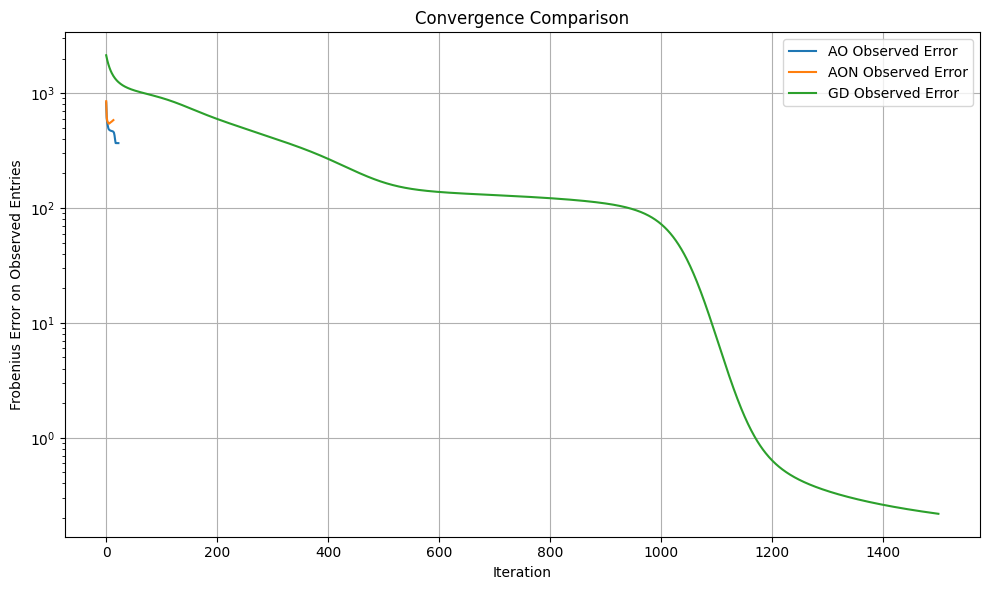

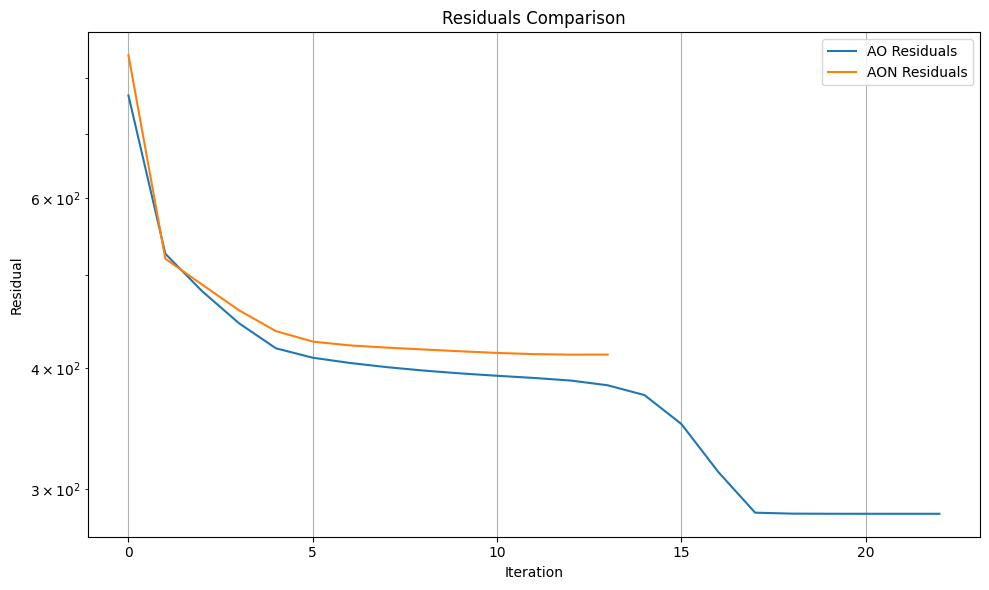

In [4]:
# Benchmark the different initialization strategies
print("=== Gaussian Initialization ===")
u0_g, v0_g = initialize_uv(X_obs, mask, strategy='gaussian', seed=seed)
# Benchmark the different solvers
gauss = compare_solvers(X_obs, X_true, u0_g.copy(), v0_g.copy(), mask, plot=True)


=== SVD Initialization ===
=== Alternating Optimization (AO) ===
AO: Residual=0.000000, Observed Error=0.00000017, Full Error=0.00000159, Iter=59, Time=0.1043s

=== AO with Normalization (AON) ===
AON: Residual=0.000000, Observed Error=0.00000004, Full Error=0.00000021, Iter=74, Time=0.1358s

=== Gradient Descent (GD) ===
GD: Residual=0.032885, Observed Error=0.13599073, Full Error=1.91853388, Iter=1500, Time=0.0591s


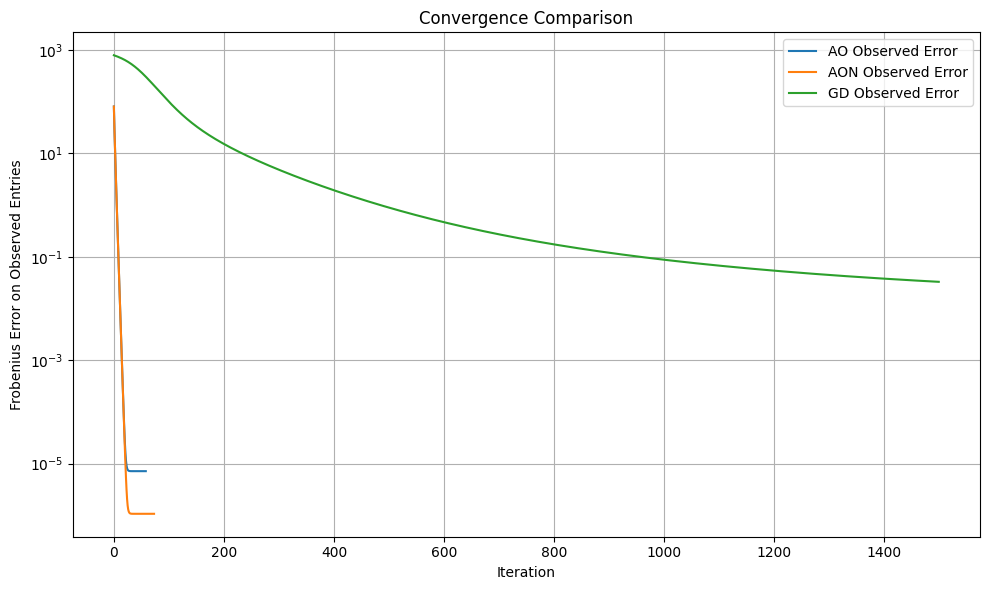

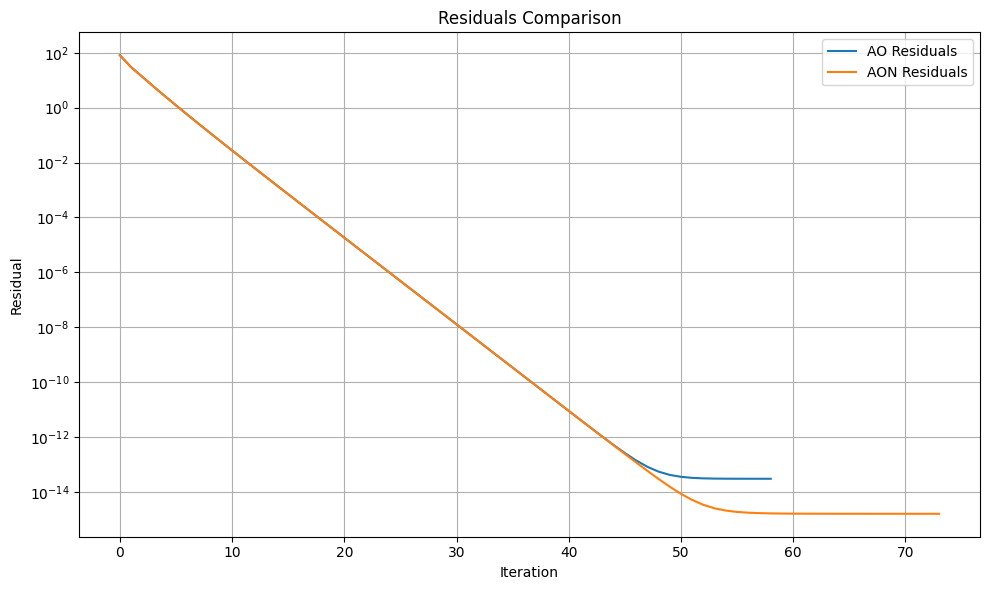

In [5]:
print("\n=== SVD Initialization ===")
u0_s, v0_s = initialize_uv(X_obs, mask, strategy='svd', seed=seed)
svd = compare_solvers(X_obs, X_true, u0_s.copy(), v0_s.copy(), mask, plot=True, lambda_r=[1e-8, 1e-10])


=== SVD + Noise Initialization ===
=== Alternating Optimization (AO) ===
AO: Residual=0.000000, Observed Error=0.00000041, Full Error=0.00000379, Iter=56, Time=0.0947s

=== AO with Normalization (AON) ===
AON: Residual=0.000000, Observed Error=0.00000004, Full Error=0.00000021, Iter=73, Time=0.1339s

=== Gradient Descent (GD) ===
GD: Residual=0.024656, Observed Error=0.10137008, Full Error=1.34181109, Iter=1500, Time=0.0628s


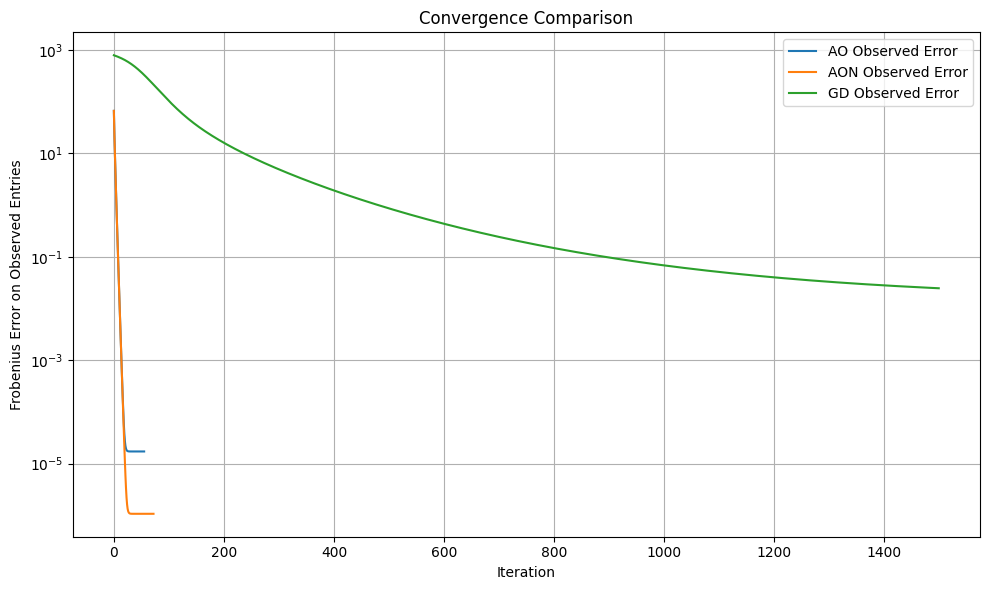

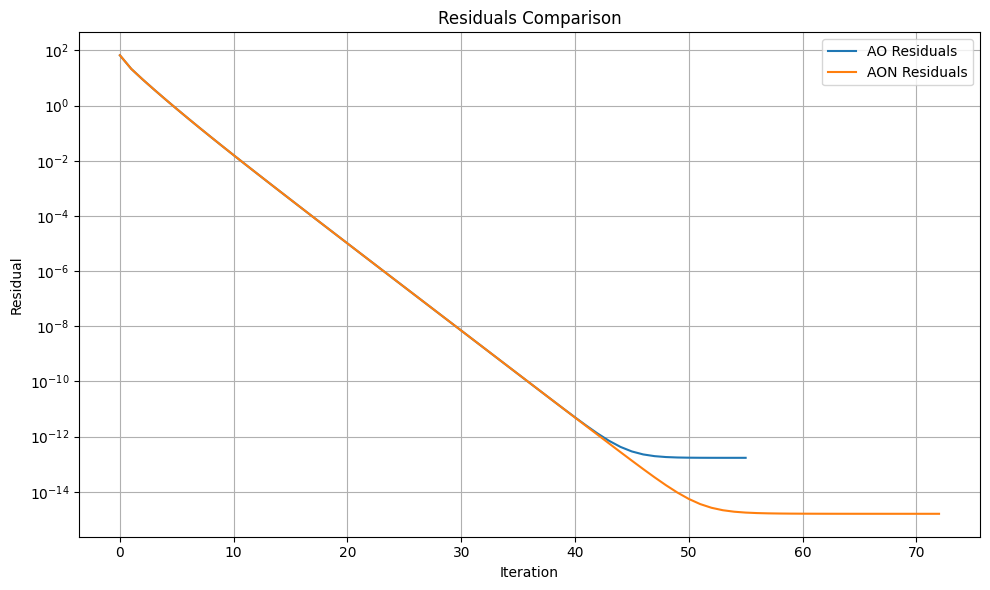

In [6]:
print("\n=== SVD + Noise Initialization ===")
u0_sn, v0_sn = initialize_uv(X_obs, mask, strategy='svd', epsilon=0.1, seed=seed)
svd_n = compare_solvers(X_obs, X_true, u0_sn.copy(), v0_sn.copy(), mask, plot=True, lambda_r=[3e-8, 1e-10])


=== Mean Initialization ===
=== Alternating Optimization (AO) ===
AO: Residual=3.794935, Observed Error=3.79493522, Full Error=20.30003528, Iter=74, Time=0.1387s

=== AO with Normalization (AON) ===
AON: Residual=1.844299, Observed Error=1.84429897, Full Error=8.75724766, Iter=55, Time=0.1065s

=== Gradient Descent (GD) ===
GD: Residual=40.011229, Observed Error=6.31779304, Full Error=34.18733818, Iter=1500, Time=0.0577s


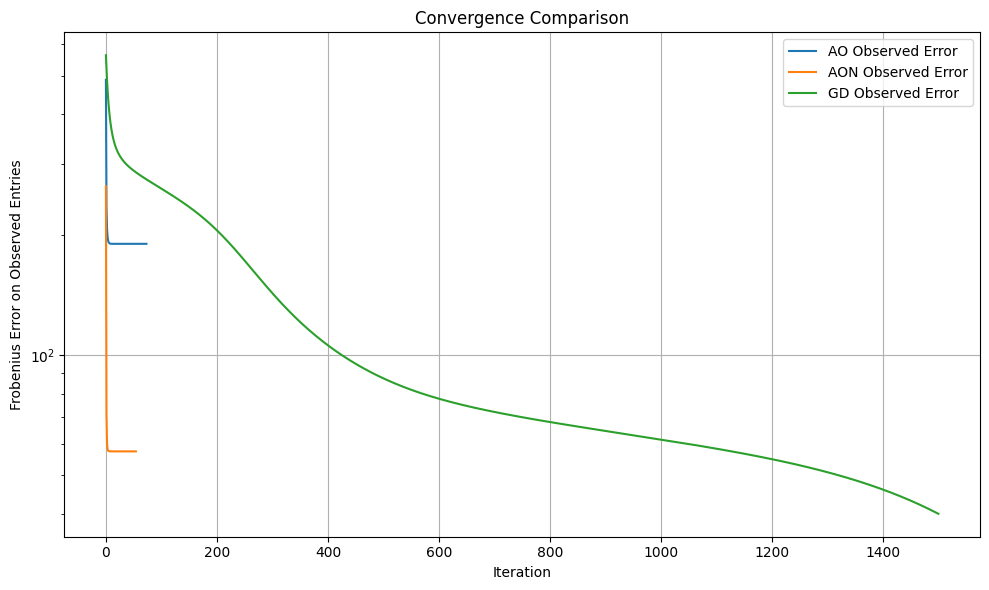

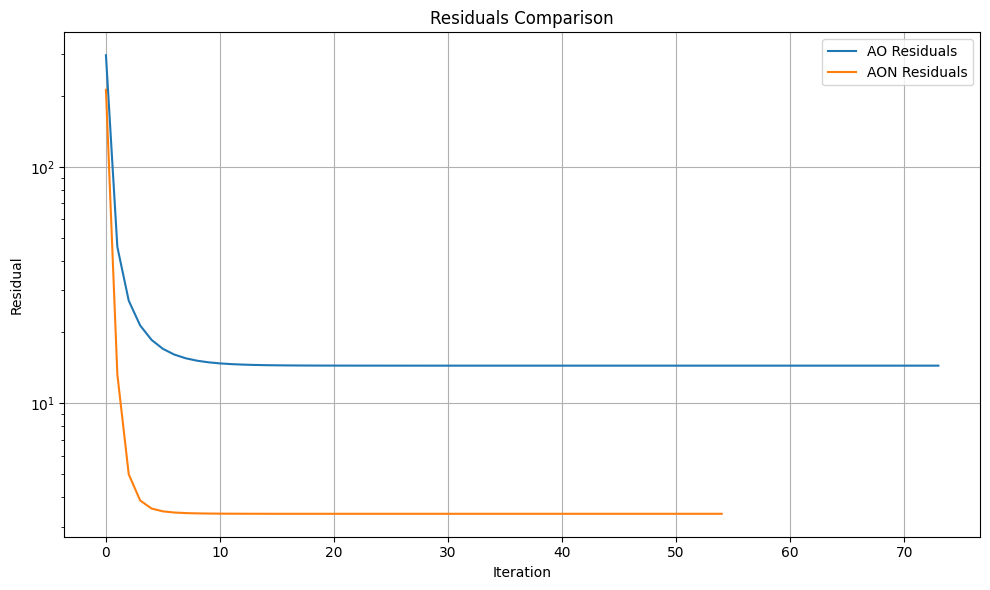

In [7]:
print("\n=== Mean Initialization ===")
u0_m, v0_m = initialize_uv(X_obs, mask, strategy='mean', seed=seed)
mean = compare_solvers(X_obs, X_true, u0_m.copy(), v0_m.copy(), mask, plot=True, lambda_r=[1e-0, 5.80e-03])

In [8]:
# compare the results of the different initializations and solvers in a table
import pandas as pd
from tabulate import tabulate

# Create a DataFrame to store the results
results_ao = pd.DataFrame({
    'Method': ['Gaussian', 'SVD', 'SVD + Noise', 'Mean'],
    'Observed Error': [
        gauss['AO']['observed_error'],
        svd['AO']['observed_error'],
        svd_n['AO']['observed_error'],
        mean['AO']['observed_error']
    ],
    'Full Error': [
        gauss['AO']['full_error'],
        svd['AO']['full_error'],
        svd_n['AO']['full_error'],
        mean['AO']['full_error']
    ]
})
# Convert the DataFrame to a string table
table_str = tabulate(results_ao, headers='keys', tablefmt='pretty', showindex=False)
# Print the table
print("=== Alternating Optimization (AO) ===")
print(table_str)

results_aon = pd.DataFrame({
    'Method': ['Gaussian', 'SVD', 'SVD + Noise', 'Mean'],
    'Observed Error': [
        gauss['AON']['observed_error'],
        svd['AON']['observed_error'],
        svd_n['AON']['observed_error'],
        mean['AON']['observed_error']
    ],
    'Full Error': [
        gauss['AON']['full_error'],
        svd['AON']['full_error'],
        svd_n['AON']['full_error'],
        mean['AON']['full_error']
    ]
})

# Convert the DataFrame to a string table
table_str = tabulate(results_aon, headers='keys', tablefmt='pretty', showindex=False)
# Print the table
print("=== Alternating Optimization with Normalization (AON) ===")
print(table_str)

results_gd = pd.DataFrame({
    'Method': ['Gaussian', 'SVD', 'SVD + Noise', 'Mean'],
    'Observed Error': [
        gauss['GD']['observed_error'],
        svd['GD']['observed_error'],
        svd_n['GD']['observed_error'],
        mean['GD']['observed_error']
    ],
    'Full Error': [
        gauss['GD']['full_error'],
        svd['GD']['full_error'],
        svd_n['GD']['full_error'],
        mean['GD']['full_error']
    ]
})
# Convert the DataFrame to a string table
table_str = tabulate(results_gd, headers='keys', tablefmt='pretty', showindex=False)
# Print the table
print("=== Gradient Descent (GD) ===")
print(table_str)



=== Alternating Optimization (AO) ===
+-------------+------------------------+------------------------+
|   Method    |     Observed Error     |       Full Error       |
+-------------+------------------------+------------------------+
|  Gaussian   |   16.814152950608726   |   118.05461831929235   |
|     SVD     | 1.734252648350406e-07  | 1.5906926949830527e-06 |
| SVD + Noise | 4.1231371185660747e-07 | 3.7855326529854084e-06 |
|    Mean     |   3.794935218194277    |   20.300035275493162   |
+-------------+------------------------+------------------------+
=== Alternating Optimization with Normalization (AON) ===
+-------------+-----------------------+------------------------+
|   Method    |    Observed Error     |       Full Error       |
+-------------+-----------------------+------------------------+
|  Gaussian   |  20.329952559648383   |   145.42779114805117   |
|     SVD     | 3.987980536763035e-08 | 2.066742742676034e-07  |
| SVD + Noise | 3.987992882954231e-08 | 2.066757539